# CE-40719: Deep Learning
## Final Project

#### Name: Mahdi Amiri
#### Student No.: 98208592


In this notebook, we are going to implement the final project of the course. We will describe each part shortly.

## 1. Imports and setup:

###1.1. Setup Drive


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
# %cd /gdrive/My\ Drive/Deep Learning Project

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


###1.2. Importing Libraries

In [22]:
# Imports
import torch
import os
import torch.nn as nn
import torch.nn.utils
import torch.nn.functional as F
import torchvision.models as models
import torchvision
import pickle
from torchvision import transforms
from torch.nn.utils.rnn import pack_padded_sequence as pack
from torch.nn.utils.rnn import pad_packed_sequence as unpack
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm.auto import tqdm
import pandas as pd
from PIL import Image 
from skimage import io, transform
from nltk import word_tokenize
from typing import List, Dict
from pprint import pprint
import unicodedata
from itertools import chain
from collections import Counter
import random
import json
import re
import time
import math
import matplotlib.pyplot as plt

import nltk  
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
# Setting the device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

START_TOKEN = '<START>'
END_TOKEN = '<END>'
PAD_TOKEN = '<PAD>'

PAD_IDX = 0
START_IDX = 1
END_IDX = 2

cuda


### 1.3. Helper Functions

We define some helpful fuctions here

In [23]:
def tokenize(corpus: List[str]) -> List[List[str]]:
    """ tokenizes the corpus and returns it as a list of list of tokens
    corpus: Input corpus as a list of sentences (each sentence is a string)
    """
    temp = [x.lower() for x in corpus]
    tokenized = [word_tokenize(x) for x in temp]
    return tokenized



def ImageResize(image):

    size = image.size
    max_size = max(size[0], size[1])
    diff = abs(size[0] - size[1])
    if size[0] > size[1]:
      target = transforms.functional.pad(image, (0, diff//2,0,diff - diff//2))
    else:
      target = transforms.functional.pad(image, (diff//2,0,diff - diff//2,0))
    
    target = transforms.functional.resize(target, (224,224))
    out = transforms.functional.to_tensor(target)
    return out

    

###1.4. Downloading Dataset

In [ ]:
! wget -q "https://drive.google.com/uc?export=download&id=1-3tnHTdDjtMd9O2LgKN2ir3t5KvnqrXI" -O dataset.zip
! unzip dataset.zip

import subprocess
import shlex

file_id = "1xhiGDTihHYUbGES88sYt4S6nLDjKEji1"
file_name = "mscoco.zip"
url_get_cookie = f"https://drive.google.com/uc?export=download&id={file_id}"

! curl -sc /tmp/cookie "{url_get_cookie}" > /dev/null
code = subprocess.run(shlex.split("awk '/_warning_/ {print $NF}' /tmp/cookie"),
                      stdout=subprocess.PIPE).stdout.decode('utf8').strip()
url_download = f"https://drive.google.com/uc?export=download&confirm={code}&id={file_id}"
! curl -Lb /tmp/cookie "{url_download}" -o {file_name} 

! unzip -q mscoco.zip

In [9]:
! unzip "/content/gdrive/My Drive/mscoco.zip" -d ./

Streaming output truncated to the last 5000 lines.
  inflating: ./mscoco/COCO_train2014_000000486641.jpg  
  inflating: ./mscoco/COCO_train2014_000000486713.jpg  
  inflating: ./mscoco/COCO_train2014_000000486717.jpg  
  inflating: ./mscoco/COCO_train2014_000000486718.jpg  
  inflating: ./mscoco/COCO_train2014_000000486732.jpg  
  inflating: ./mscoco/COCO_train2014_000000486793.jpg  
  inflating: ./mscoco/COCO_train2014_000000486807.jpg  
  inflating: ./mscoco/COCO_train2014_000000486821.jpg  
  inflating: ./mscoco/COCO_train2014_000000486854.jpg  
  inflating: ./mscoco/COCO_train2014_000000486869.jpg  
  inflating: ./mscoco/COCO_train2014_000000486870.jpg  
  inflating: ./mscoco/COCO_train2014_000000486906.jpg  
  inflating: ./mscoco/COCO_train2014_000000486936.jpg  
  inflating: ./mscoco/COCO_train2014_000000486960.jpg  
  inflating: ./mscoco/COCO_train2014_000000486972.jpg  
  inflating: ./mscoco/COCO_train2014_000000486977.jpg  
  inflating: ./mscoco/COCO_train2014_000000486983.jpg

## 2. Vocab
In this section we build the corpus from csv file and a Vocab on it

In [25]:
data_frame = pd.read_csv('dataset/dataset.train.csv')

corpus = []
for i in range(len(data_frame)):
  corpus.append(data_frame.iloc[i,2])

data_frame = pd.read_csv('dataset/dataset.valid.csv') 
for i in range(len(data_frame)):
  corpus.append(data_frame.iloc[i,2])

corpus = tokenize(corpus)



In this section, we use the same class we implemented in HW4.

In [26]:
class Vocab:
    def __init__(self, word2id=None):
        """Constructor of Vocab

        word2id: dictionary that maps tokens to their ids.
        """
        self.pad_token = '<PAD>'
        self.end_token = '<END>'
        self.start_token = '<START>'
        self.unk_token = '<UNK>'

        if word2id is None:
            self.word2id = {self.pad_token: 0,
                            self.start_token: 1,
                            self.end_token: 2,
                            self.unk_token: 3}
            self.size = 4
        else:
            self.word2id = word2id
            self.size = len(self.word2id)

        self.id2word = {v: k for (k, v) in self.word2id.items()}

    def build(self, tokenized_corpus: List[List[str]], size=None, min_freq=None):
        """Builds the vocab from a tokenized corpus.

        tokenized_corpus: corpus as a list of list of tokens (strings)
        size: Final size of (number of unique tokens in) our vocab
        min_freq: minimum frequency
        """
        tokens2freq = Counter(chain(*tokenized_corpus))  # dict that maps unique tokens to their freqs in the corpus
        frequent_tokens = []
        ################################################################################
        # TODO: use tokens2freq and find the first size frequent tokens and save       #
        #       them in frequent_tokens. Remove tokens with a frequency lower than     #
        #       min_freq (i.e. if token's occurence in the corpus is less than         # 
        #       min_freq times, don't put the token in frequent_tokens).               #
        #       If size is None, then use all of the tokens. This also applies to      #
        #       min_freq.                                                              #
        ################################################################################
        frequent_tokens = [v for v in tokens2freq]
        if min_freq != None:
          for items in frequent_tokens:
            if tokens2freq[items] <  min_freq:
              frequent_tokens.remove(items)


        if len(frequent_tokens) == None:
            frequent_tokens = [v for v in tokens2freq]
            
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        # adding tokens to the vocab
        for token in frequent_tokens:
            self.add_token(token)

        self.size = len(self.word2id)

    def get_token_by_id(self, t_id: int) -> str:
        """Returns the token with the corresponding id in the vocab.
        If the id is not valid, returns None.

        t_id: token id
        """
        return self.id2word.get(t_id, None)

    def get_id_by_token(self, token: str) -> int:
        """Returns the id of the token in the vocab. If the token does not exist,
        returns the id of <UNK> token.

        token: token (as a string) for which the id should be returned.
        """
        return self.word2id.get(token, self.word2id[self.unk_token])

    def add_token(self, token: str):
        """Adds the token to the vocab's data structures
        token: token as a string
        """
        ################################################################################
        # TODO: If the token is not already in the vocab add it to word2id and id2word #
        # Don't forget to update the vocab size afterwards!                            #
        ################################################################################
        pass
        if token not in self.word2id:
            self.word2id[token] = self.size
            self.id2word[self.size] = token
            self.size += 1
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

    def tokens2ids(self, sents):
        """Convert list of words or list of sentences of tokens 
        into list or list of list of indices.

        sents: input sentences as List[List[str]] (multiple sentences) or List[str]
        (single sentence)
        """
        output = []
        ################################################################################
        # TODO: return a new list where each token is repalced by its id.              #
        # HINT: try to implement each part in one line of code using list comprehension#
        ################################################################################
        if type(sents[0]) == list:
          output = sents
          for i ,item in enumerate(sents):
            output[i] = [self.word2id[x] if x in self.word2id else self.word2id['<UNK>'] for x in item]
        else:
            output = [self.word2id[x] if x in self.word2id else self.word2id['<UNK>'] for x in sents]

        return output
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
  
    def to_tensor(self, sent: List[str]):
        """Converts a sentence as a list of tokens into a tensor of indices.

        sent: a sentence as a list of strings (tokens)
        """
        ################################################################################
        # TODO: Use self.tokens2ids to get the sentence as a list of indices and wrap a#
        #       tensor around it with dtpye of torch.long and device of DEVICE.        #
        ################################################################################

        out = torch.tensor(self.tokens2ids(sent), dtype= torch.long, device= DEVICE)

        return out
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

    def pad_sents(self, sents: List[List[str]]) -> List[List[str]]:
        """Pads list of sentences according to the longest sentence.

        sents: sentences as a list of list of tokens (strings).
        """
        sents_padded = []
        ################################################################################
        # TODO: pad shorter sentences by appending pad token to them.                  #
        ################################################################################
        sents_padded = sents
        max_len = len(max(sents,key=len))

        for item in sents_padded:
            if len(item) < max_len:
                item.extend(['<PAD>'] * (max_len - len(item)))
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        return sents_padded

    def save(self, path: str):
        """Saves the vocab in a json file.

        path: path to save the vocab in
        """
        with open(path, 'w') as f:
            json.dump(self.word2id, f)

    @staticmethod
    def load(path: str):
        """Loads vocab from a json file.

        path: path to load the vocab from
        """
        with open(path, 'r') as f:
            word2id = json.load(f)

        return Vocab(word2id)

Now we build a vocab on corpus

In [27]:
sent_vocab = Vocab()
sent_vocab.build(corpus,min_freq=3)

print('Sentences Vocab Size:', sent_vocab.size)
print(sent_vocab.word2id)

Sentences Vocab Size: 8246
{'<PAD>': 0, '<START>': 1, '<END>': 2, '<UNK>': 3, 'a': 4, 'giraffe': 5, 'standing': 6, 'behind': 7, 'another': 8, 'facing': 9, 'the': 10, 'camera': 11, '.': 12, 'foremost': 13, 'on': 14, 'right': 15, 'front': 16, 'most': 17, 'in': 18, 'picture': 19, 'peeking': 20, 'around': 21, 'dark': 22, 'lamb': 23, 'bottles': 24, 'of': 25, 'beer': 26, 'pizza': 27, 'being': 28, 'touched': 29, 'by': 30, 'man': 31, 'with': 32, "'s": 33, 'hands': 34, 'over': 35, 'it': 36, 'male': 37, 'tennis': 38, 'player': 39, 'swinging': 40, 'racket': 41, 'person': 42, 'wearing': 43, 'purple': 44, 't-shirt': 45, 'and': 46, 'blue': 47, 'jeans': 48, 'next': 49, 'to': 50, 'chair': 51, 'shirt': 52, 'holding': 53, 'two': 54, 'wii': 55, 'controllers': 56, 'dancing': 57, 'woman': 58, 'remotes': 59, 'girl': 60, 'controlers': 61, 'baseball': 62, 'pitcher': 63, 'jersey': 64, 'number': 65, '21': 66, 'ball': 67, 'his': 68, 'hand': 69, 'second': 70, 'base': 71, 'getting': 72, 'ready': 73, 'play': 74, 'l

## 3. Bulding Dataset
We build a custum dataset on csv file. We use 

In [28]:
class MyDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform_sent=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.frames = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform_sent = transform_sent

    def __len__(self):
        return len(self.frames)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        ############## id to crop location ############
        crop_loc = self.frames.iloc[idx, 3].split ("[")[1].split("]")[-2].split()
        crop_loc = [float(i) for i in crop_loc]
        ############## id to image ############
        img_name = os.path.join(self.root_dir, self.frames.iloc[idx, 1])
        # image = io.imread(img_name)
        # print(image.shape)
        image = Image.open(img_name )
        image = image.convert('RGB')
        croped_image = torchvision.transforms.functional.crop(image , int(crop_loc[1]), int(crop_loc[0]), int(crop_loc[3]),int(crop_loc[2]))
        
        image = ImageResize(image)
        croped_image = ImageResize(croped_image)

        # ImageResize
        # croped_image = image[int(crop_loc[1]):int(crop_loc[1])+int(crop_loc[3]), int(crop_loc[0]):int(crop_loc[0] + int(crop_loc[2]))]
        # image = ImageResize(image)
        # croped_image = ImageResize(croped_image)
        
        # croped_image = transform.resize(croped_image, (224, 224))
        # croped_image = croped_image.transpose((2, 0, 1))

        # image = transform.resize(image, (224, 224))
        # image = image.transpose((2, 0, 1))
        ############## id to sentence ############
        sentence = self.frames.iloc[idx, 2]
        sentence = sentence.lower()
        sentence = word_tokenize(sentence)
        sentence.insert(0, '<START>')
        sentence.append('<END>')
        # print(sentence)
        if self.transform_sent:
          sentence = self.transform_sent(sentence)

        sample = {'image': image, 'croped_image': croped_image ,'sentence': sentence, 'crop_loc': crop_loc}

        return sample


class ToTensor(object):
    """A callable transform that converts sentences to Tensors.
    """
    def __init__(self, src_vocab: Vocab):
        self.src_vocab = src_vocab

    def __call__(self, sents: Dict):
        return self.src_vocab.to_tensor(sents)

In [29]:
def pad_tensor(tensor: torch.Tensor, size: int, dim: int=-1):
    """
    tensor: tensor to pad
    size: the size to pad to
    dim: dimension to pad

    returns a new tensor padded to 'size' in dimension 'dim'
    """
    pad_size = list(tensor.shape)
    pad_size[dim] = size - tensor.size(dim)
    pad = torch.full(pad_size, PAD_IDX, dtype=tensor.dtype, device=tensor.device)

    return torch.cat([tensor, pad], dim=dim)


# Thanks to https://discuss.pytorch.org/t/dataloader-for-various-length-of-data/6418/8
class PadCollate:
    """
    a variant of callate_fn that pads according to the longest sequence in
    a batch of sequences
    """
    def __init__(self, dim=-1):
        """
        dim: the dimension to be padded (e.g., dimension of time in sequences)
        """
        self.dim = dim

    def pad_collate(self, batch):
        """
        batch: a batch of data as a list of Dictionaries

        returns:
          src_sents: tensor of source sentences
          tgt_sents: tensor of target sentences
          src_lengths: lengths of source sentences before padding as a list 
        """

        # sort pairs based on the lengths of source sentences
        batch = sorted(batch, key=lambda pair: pair['sentence'].size(0), reverse=True)
        sent_length = [pair['sentence'].size(0) for pair in batch]

        # find longest sequence
        max_len = max(map(lambda pair: pair['sentence'].shape[self.dim], batch))

        # pad according to max_len
        sentence = [pad_tensor(pair['sentence'], size=max_len, dim=self.dim) for pair in batch]
        sents = torch.stack(sentence, dim=-1)

        crop = [torch.tensor(pair['crop_loc']) for pair in batch]
        crop = torch.stack(crop, dim=0)

        im = [pair['image'] for pair in batch]
        image = torch.stack(im, dim=0)

        croped_image = [pair['croped_image'] for pair in batch]
        croped_image = torch.stack(croped_image, dim=0)

        return image, croped_image, sents, crop, sent_length

    def __call__(self, batch):
        return self.pad_collate(batch)

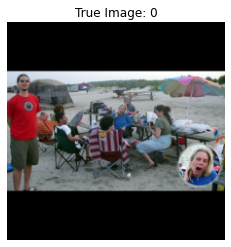

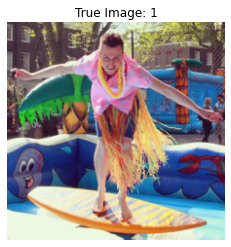

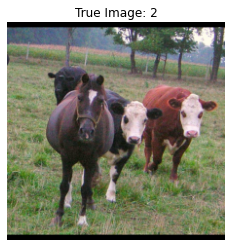

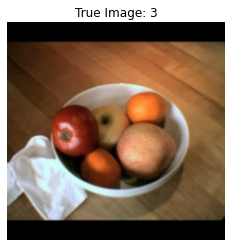

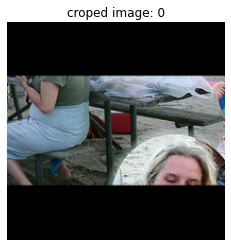

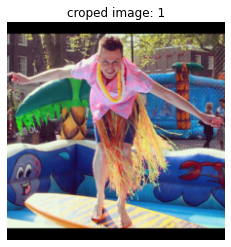

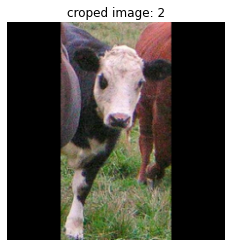

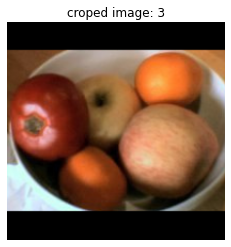

The sentences tensor (Seq , Batch) is:
tensor([[   1,    1,    1,    1],
        [  10,    4,    4,  271],
        [  15,   31,  707,   10],
        [ 269,   18,  121,  495],
        [  25,    4,  433,  218],
        [   4,  114, 2257, 1756],
        [ 144,   52,   32,   18],
        [  32, 1005,    4,  480],
        [   4,   14,   80,   12],
        [  58,    4,  330,    2],
        [  18,  247,    2,    0],
        [   4,  404,    0,    0],
        [ 127,   12,    0,    0],
        [  52,    2,    0,    0],
        [  12,    0,    0,    0],
        [   2,    0,    0,    0]], device='cuda:0')
The crop locations tensor (Batch , 4) is:
tensor([[403.2000, 159.0900, 211.2000, 106.0500],
        [  9.6300,  24.7600, 598.2400, 534.9800],
        [222.1300, 141.2600, 132.0500, 260.0100],
        [ 69.1200,  79.8600, 210.1000, 155.0600]])
The sentences length tensor (Seq ) is:
[16, 14, 11, 10]


In [30]:
################# testing dataset and dataloader #########################
face_dataset = MyDataset(csv_file= 'dataset/dataset.train.csv', root_dir='mscoco', transform_sent=ToTensor(sent_vocab))

datax = DataLoader(face_dataset, batch_size=4,
                        shuffle=True, num_workers=0, collate_fn = PadCollate())

for i, ci , s , cr , l  in datax:
  for c  in range(i.shape[0]):
    plt.imshow(np.transpose(i[c],(1,2, 0)))
    plt.title("True Image: {}".format(c))
    # print(i[c].shape)
    plt.axis('off')
    plt.show()

  for c  in range(ci.shape[0]):
    plt.imshow(np.transpose(ci[c],(1,2, 0)))
    plt.title("croped image: {}".format(c))
    # print(ci[c].shape)
    plt.axis('off')
    plt.show()

  print('The sentences tensor (Seq , Batch) is:')
  print(s)
  print('The crop locations tensor (Batch , 4) is:')
  print(cr)
  print('The sentences length tensor (Seq ) is:')
  print(l)
  break


##4. Generation Task

### 4.1. Defining Generator using LSTM and ResNet50
In this section, we define a model for generating text to caption cropped image

In [13]:
class GeneratorNet(nn.Module):
    def __init__(self, feature_size: int, hidden_size: int, embed_size: int, vocab_size: int, dropout_rate=0.2):
        
        super(GeneratorNet, self).__init__()
        self.hidden_size = hidden_size
        self.vocab_embedding = nn.Embedding(vocab_size, embed_size, padding_idx=PAD_IDX)
        self.rnn = nn.LSTM(embed_size + 2*feature_size, hidden_size)
        self.vocab_projection = nn.Linear(hidden_size, vocab_size, bias= False)
        self.bridge = nn.Linear(2*feature_size, hidden_size, bias= False)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.my_model =  models.resnet50(pretrained= True)#models.vgg16_bn(pretrained= True)#

        # for p in self.my_model.parameters():
        #     p.requires_grad_(False)

        # for p in self.my_model.fc.parameters():
        #     p.requires_grad_(True) 


    def init_weights(self, val: float):
        for param in self.rnn.parameters():
            torch.nn.init.uniform_(param.data, a= -val, b= +val)

    def forward(self, image: torch.Tensor, image_c: torch.Tensor, tgt: torch.Tensor):
        
        tgt_d = tgt[:-1]
        embedded = self.vocab_embedding(tgt_d)
        seq_len = embedded.size(0)
        batch_size = image.size(0)

        VGG_features_i =  self.my_model(image)
        VGG_features_c =  self.my_model(image_c)

        feature_cat = torch.cat((VGG_features_i,VGG_features_c), dim=-1)
        feature_in = torch.stack([feature_cat for i in range(seq_len)], dim=0)
        ybar = torch.cat((embedded, feature_in), dim= -1)

        h_init = self.bridge(feature_cat)
        h_init = h_init.unsqueeze(0)
        c_init = torch.zeros((1,batch_size, self.hidden_size), device= DEVICE)

        dec_state, _ = self.rnn(ybar, (h_init,c_init))
        
        logits = self.vocab_projection(dec_state)
        log_probs = F.log_softmax(logits, dim= -1)

        tgt_mask = (tgt != PAD_IDX).float()
        tgt_gold_words_log_prob = torch.gather(log_probs, index=tgt[1:].unsqueeze(-1), dim=-1).squeeze(-1)*tgt_mask[1:]
        scores = tgt_gold_words_log_prob.sum(dim=0)

        return logits, scores


    def greedy_decode(self, image: torch.Tensor, image_c: torch.Tensor, sent_vocab: Vocab, max_length: int = 50):
       
        decoded_sent = []
        combined_seq = []

        seq_input = 1

        VGG_features_i =  self.my_model(image.unsqueeze(0))
        VGG_features_c =  self.my_model(image_c.unsqueeze(0))

        feature_in = torch.cat((VGG_features_i,VGG_features_c), dim=-1)

        h_init = self.bridge(feature_in)
        h_init = h_init.unsqueeze(0)
        c_init = torch.zeros((1,VGG_features_i.size(0), self.hidden_size), device= DEVICE)

        inits = (h_init,c_init)

        i = 0
        while i<max_length and seq_input != 2:

            embedded = self.vocab_embedding(torch.tensor(seq_input).to(DEVICE)).reshape(1,-1)

            ybar = torch.cat((embedded, feature_in), dim= -1).unsqueeze(0)
            dec_state, inits = self.rnn(ybar, inits)
            logits = self.vocab_projection(dec_state)
            _ , index = torch.max(logits.squeeze(), 0)
            seq_input = int(index)
            combined_seq.append(seq_input)
            i+=1

        decoded_sent = [sent_vocab.get_token_by_id(x) for x in combined_seq]
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

        return decoded_sent

### 4.2. Training Loop

In [17]:
batch_size = 16


train_dataset = MyDataset(csv_file= 'dataset/dataset.train.csv', root_dir='mscoco', 
                          transform_sent=ToTensor(sent_vocab))

valid_dataset = MyDataset(csv_file= 'dataset/dataset.valid.csv', root_dir='mscoco', 
                          transform_sent=ToTensor(sent_vocab))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, 
                              shuffle=True, num_workers=0, collate_fn = PadCollate())

valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, 
                              shuffle=True, num_workers=0, collate_fn = PadCollate())




In [10]:
model = GeneratorNet(1000, 1024, 1024, sent_vocab.size)
model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=4,gamma=0.1)

Epoch: 1
>>> loss: 44.969', batch number= 500
>>> loss: 41.281', batch number= 1000
>>> loss: 39.244', batch number= 1500
>>> loss: 37.722', batch number= 2000
>>> loss: 36.716', batch number= 2500
>>> loss: 35.776', batch number= 3000
>>> loss: 35.071', batch number= 3500
>>> loss: 34.555', batch number= 4000
>>> loss: 34.035', batch number= 4500
>>> loss: 33.546', batch number= 5000
Epoch: 2
>>> loss: 27.829', batch number= 500
>>> loss: 27.641', batch number= 1000
>>> loss: 27.587', batch number= 1500
>>> loss: 27.561', batch number= 2000
>>> loss: 27.513', batch number= 2500
>>> loss: 27.458', batch number= 3000
>>> loss: 27.373', batch number= 3500
>>> loss: 27.323', batch number= 4000
>>> loss: 27.222', batch number= 4500
>>> loss: 27.153', batch number= 5000
Epoch: 3
>>> loss: 24.505', batch number= 500
>>> loss: 24.809', batch number= 1000
>>> loss: 24.777', batch number= 1500
>>> loss: 24.781', batch number= 2000
>>> loss: 24.775', batch number= 2500
>>> loss: 24.763', batch n

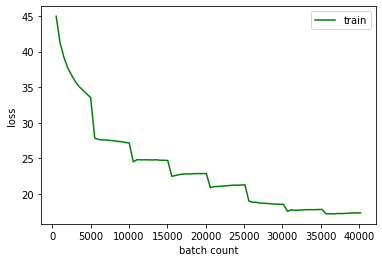

In [50]:
max_epoch = 8
log_every = 500
batch_count = 0
plot_losses_train = []
plot_losses_eval = []
x_t = []
x_v = []
################ training loop ######################
for i in range(max_epoch):
    print('Epoch:', i+1)
    running_loss = 0.0
    for batch, data in enumerate(train_dataloader):
        batch_count +=1
        model.train()
        optimizer.zero_grad()
        image, croped_image, sents, _ , _ = data
        _, score = model(image.to(DEVICE), croped_image.to(DEVICE) , sents.to(DEVICE))
        loss = -score.sum()/batch_size
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
        optimizer.step()
        running_loss += loss.item()

        if batch % log_every == log_every - 1:
            print(">>> loss: %.3f', batch number= %d" %(running_loss/(batch+1),batch + 1))
            plot_losses_train.append(running_loss/(batch+1))
            x_t.append(batch_count)

        torch.cuda.empty_cache()

    lr_scheduler.step()
    torch.save(model.state_dict(), '/content/gdrive/My Drive/models/model_res50_t_{}.chkpt'.format(str(i+1)))


plt.plot(x_t ,plot_losses_train, '-g', label='train')
# plt.plot(x_v , plot_losses_eval, '-r', label='validation')

plt.xlabel('batch count')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.show()


In [11]:
model.load_state_dict(torch.load('/content/gdrive/My Drive/models/model_res50_t_12.chkpt'))

<All keys matched successfully>


Your generation:
	 ['<START>', 'the', 'motorcycle', 'closest', 'to', 'the', 'camera', '<END>']
Ground truth sentence:
	 ['<START>', 'black', 'scooter', 'touching', 'the', 'pole', 'and', 'standing', 'near', 'the', 'white', 'scooter', '.', '<END>'] 




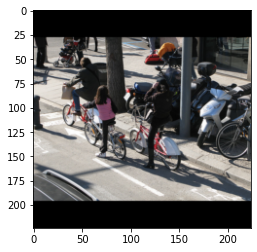

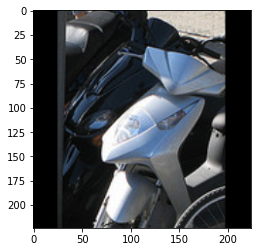


Your generation:
	 ['<START>', 'a', 'man', 'with', 'a', 'black', 'shirt', 'and', 'white', 'pants', 'sitting', 'on', 'a', 'bench', 'with', 'a', 'woman', 'in', 'a', 'white', 'shirt', '<END>']
Ground truth sentence:
	 ['<START>', 'a', 'woman', 'with', 'black', 'hair', 'and', 'sunglasses', '.', '<END>'] 




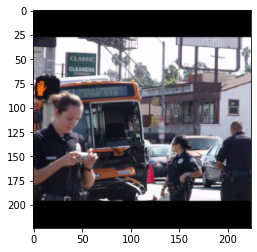

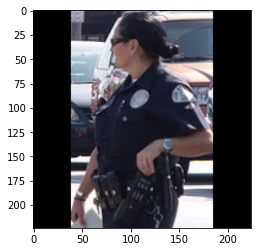


Your generation:
	 ['<START>', 'a', 'silver', 'bowl', 'with', 'a', 'spoon', 'in', 'it', '<END>']
Ground truth sentence:
	 ['<START>', 'a', 'model', 'boat', 'with', 'a', 'scalloped', 'design', 'on', 'the', 'side', '.', '<END>'] 




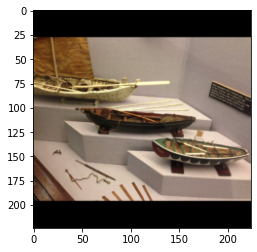

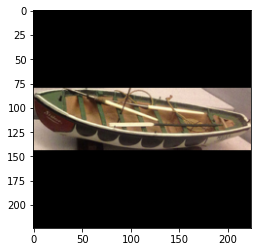


Your generation:
	 ['<START>', 'the', 'blue', 'umbrella', 'on', 'the', 'left', '<END>']
Ground truth sentence:
	 ['<START>', 'a', 'blue', 'and', 'white', 'umbrella', '<END>'] 




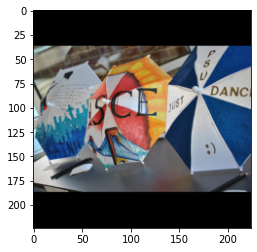

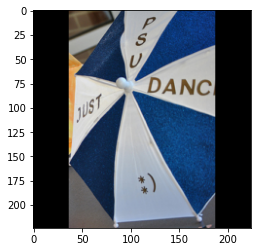


Your generation:
	 ['<START>', 'a', 'baseball', 'player', 'with', 'the', 'number', '28', 'on', 'his', 'jersey', '.', '<END>']
Ground truth sentence:
	 ['<START>', 'a', 'player', 'wearing', 'a', 'glove', 'watching', 'the', 'bats', 'man', "'", '<END>'] 




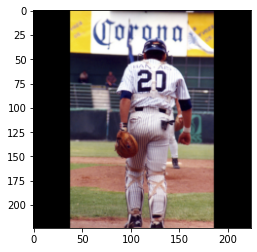

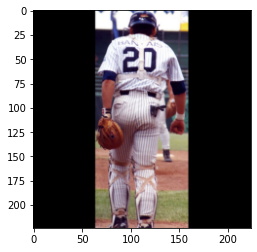


Your generation:
	 ['<START>', 'a', 'baby', 'elephant', '.', '<END>']
Ground truth sentence:
	 ['<START>', 'an', 'baby', 'elephant', 'walking', 'next', 'to', 'a', 'big', 'elephant', '<END>'] 




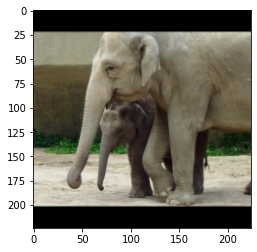

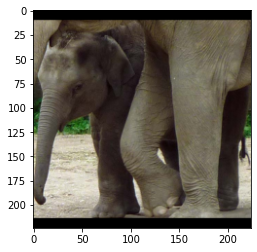


Your generation:
	 ['<START>', 'a', 'woman', 'in', 'a', 'red', 'shirt', 'and', 'white', 'pants', 'sitting', 'on', 'a', 'bench', '.', '<END>']
Ground truth sentence:
	 ['<START>', 'girl', 'in', 'red', 'shirt', '<END>'] 




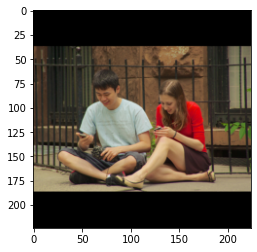

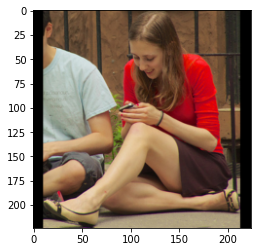


Your generation:
	 ['<START>', 'a', 'blue', 'bike', 'in', 'front', 'of', 'a', 'blue', 'bike', '.', '<END>']
Ground truth sentence:
	 ['<START>', 'bycycle', 'left', 'side', '<END>'] 




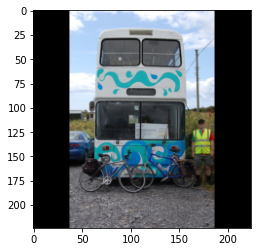

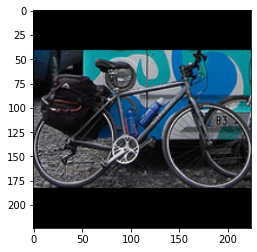


Your generation:
	 ['<START>', 'an', 'elephant', 'with', 'its', 'trunk', 'extended', '.', '<END>']
Ground truth sentence:
	 ['<START>', 'the', 'elephant', 'standing', 'on', 'the', 'tool', 'at', 'left', '.', '<END>'] 




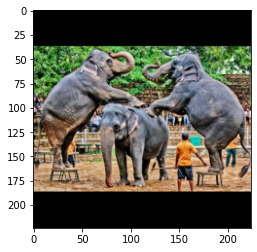

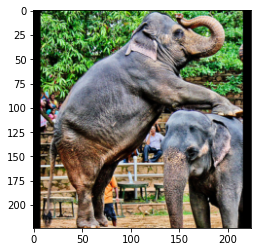


Your generation:
	 ['<START>', 'the', 'back', 'of', 'a', 'person', 'in', 'a', 'white', 'shirt', 'and', 'black', 'pants', '.', '<END>']
Ground truth sentence:
	 ['<START>', 'adult', 'person', 'on', 'the', 'left', 'behind', 'kids', '<END>'] 




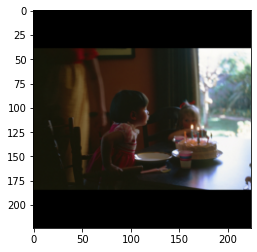

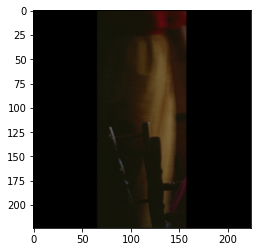


Your generation:
	 ['<START>', 'the', 'back', 'of', 'a', 'blue', 'suitcase', '.', '<END>']
Ground truth sentence:
	 ['<START>', 'a', 'gray', 'crate', 'with', 'black', 'wheels', '.', '<END>'] 




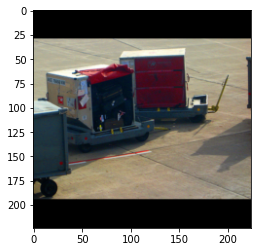

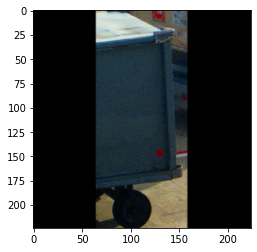


Your generation:
	 ['<START>', 'a', 'man', 'in', 'a', 'hat', 'and', 'a', 'white', 'shirt', '.', '<END>']
Ground truth sentence:
	 ['<START>', 'a', 'man', 'in', 'a', 'hat', 'holding', 'a', 'stop', 'sign', '.', '<END>'] 




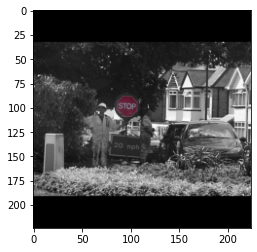

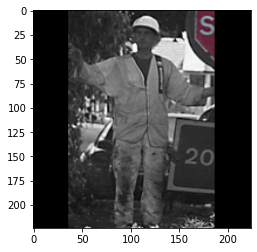


Your generation:
	 ['<START>', 'a', 'brown', 'cat', 'sitting', 'on', 'a', 'chair', '.', '<END>']
Ground truth sentence:
	 ['<START>', 'a', 'gray', 'cat', 'on', 'the', 'mat', '.', '<END>'] 




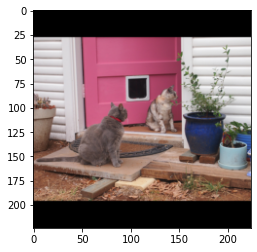

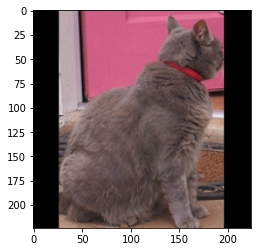


Your generation:
	 ['<START>', 'a', 'man', 'with', 'a', 'blue', 'shirt', 'and', 'a', 'baseball', 'cap', 'on', 'his', 'head', '.', '<END>']
Ground truth sentence:
	 ['<START>', 'a', 'man', 'in', 'a', 'manny', 'pacquaio', 'shirt', 'viewing', 'a', 'tablet', 'screen', 'that', 'is', 'held', 'by', 'another', 'man', '.', '<END>'] 




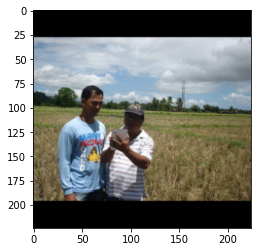

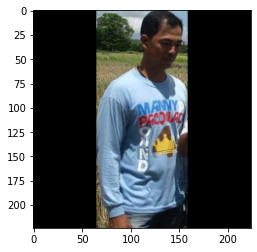


Your generation:
	 ['<START>', 'a', 'bowl', 'of', 'red', 'and', 'green', 'apples', '.', '<END>']
Ground truth sentence:
	 ['<START>', 'container', 'with', 'strawberries', ',', 'peaches', 'and', 'other', 'foods', 'inside', '.', '<END>'] 




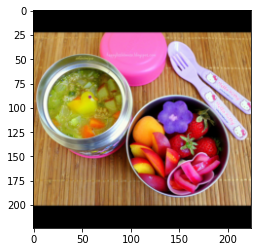

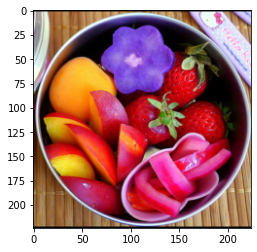


Your generation:
	 ['<START>', 'a', 'person', 'in', 'a', 'black', 'coat', 'and', 'white', 'pants', 'walking', 'away', 'from', 'the', 'camera', '.', '<END>']
Ground truth sentence:
	 ['<START>', 'the', 'silhouette', 'of', 'a', 'man', 'holding', 'an', 'umbrella', '.', '<END>'] 




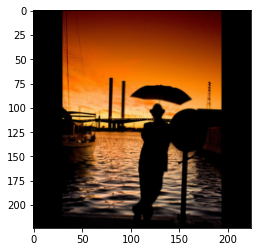

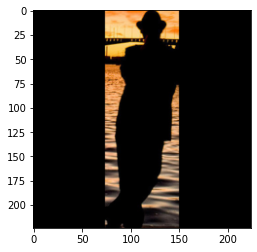


Your generation:
	 ['<START>', 'the', 'chair', 'that', 'the', 'boy', 'in', 'red', 'is', 'sitting', 'in', '<END>']
Ground truth sentence:
	 ['<START>', 'a', 'chair', 'holding', 'a', 'red', 'bag', '.', '<END>'] 




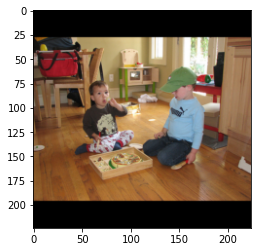

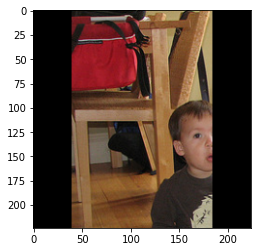


Your generation:
	 ['<START>', 'the', 'chair', 'the', 'man', 'in', 'white', 'is', 'sitting', 'in', '<END>']
Ground truth sentence:
	 ['<START>', 'a', 'chair', 'that', 'a', 'man', 'in', 'a', 'brown', 'jacket', 'is', 'sitting', 'in', '.', '<END>'] 




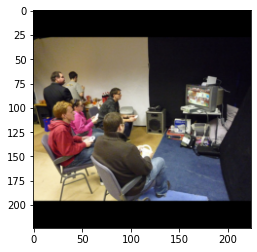

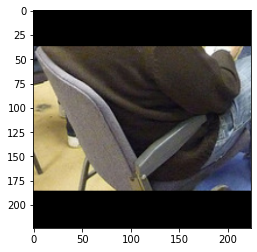


Your generation:
	 ['<START>', 'a', 'boy', 'in', 'a', 'green', 'shirt', 'with', 'a', '<UNK>', 'logo', 'on', 'his', 'head', '.', '<END>']
Ground truth sentence:
	 ['<START>', 'the', 'passenger', 'holding', 'a', 'bicycle', 'with', 'the', "'wrangler", "'", 'jacket', 'on', '.', '<END>'] 




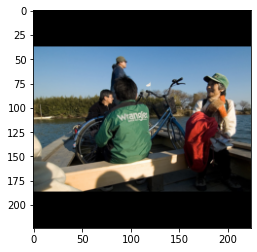

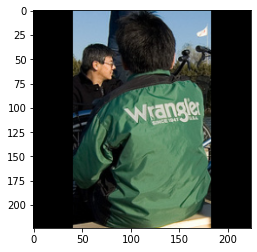


Your generation:
	 ['<START>', 'a', 'girl', 'with', 'long', 'hair', 'in', 'a', 'ponytail', '.', '<END>']
Ground truth sentence:
	 ['<START>', 'a', 'girl', 'with', 'long', 'hair', 'is', 'watching', 'tv', '.', '<END>'] 




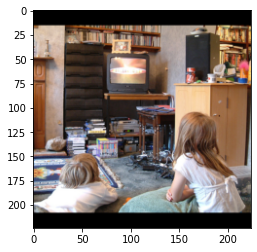

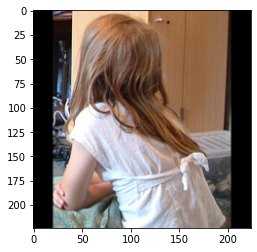

In [21]:
idxs = np.random.randint(0, len(valid_dataset), 20)
for idx in idxs:
    sent_tensor = valid_dataset[idx]['sentence']
    image = valid_dataset[idx]['image']
    image_c  = valid_dataset[idx]['croped_image']
    print()
    true_sent = [sent_vocab.get_token_by_id(el.item()) for el in sent_tensor]

    print('Your generation:\n\t', ['<START>'] + model.greedy_decode(image.to(DEVICE), image_c.to(DEVICE), sent_vocab))
    print('Ground truth sentence:\n\t', true_sent, '\n\n')
    plt.imshow(np.transpose(image,(1,2, 0)))
    plt.show()
    plt.imshow(np.transpose(image_c,(1,2, 0)))
    plt.show()

### 4.3. Bleu Score 
In this section we will use a given function to compute bleu1 and bleu2 score.

In [23]:
import sys, argparse
from nltk.translate.bleu_score import corpus_bleu

def eval_bleu(target_df, predicated_sentences, ngram):
  list_of_references = []
  list_of_hypotheses = []
  for i in range(len(target_df)):
    image_fname = target_df.loc[i, 'image_fname']
    box = target_df.loc[i, 'box']
    similar_rows = target_df[ (target_df['image_fname'] == image_fname) & (target_df['box'] == box) ]
    refrences = [ sentence.split() for sentence in similar_rows['sentence'] ]
    hypotheses = predicated_sentences[i].split()
    list_of_references.append(refrences)
    list_of_hypotheses.append(hypotheses)
  weights = [1/ngram for _ in range(ngram)]
  return corpus_bleu(list_of_references, list_of_hypotheses, weights=weights)



Now we compute these scores due to the fuction and trained model.

In [24]:
valid_dataset = MyDataset(csv_file= 'dataset/dataset.valid.csv', root_dir='mscoco', 
                          transform_sent=ToTensor(sent_vocab))

frames = pd.read_csv('dataset/dataset.valid.csv')


sentences = []
with torch.no_grad():
    model.eval()
    for idx in range(len(valid_dataset)):
        image = valid_dataset[idx]['image']
        image_c  = valid_dataset[idx]['croped_image']
        temp = model.greedy_decode(image.to(DEVICE), image_c.to(DEVICE), sent_vocab)
        temp = temp[0:-1]
        listToStr = ' '.join(temp)
        sentences.append(listToStr)

bleu1 =  eval_bleu(frames, sentences, 1)
print('bleu1 measure is:', bleu1)

bleu2 =  eval_bleu(frames, sentences, 2)
print('bleu2 measure is:', bleu2)

bleu1 measure is: 0.33519662008449785
bleu2 measure is: 0.19270403760108792


##5. Comprehension Task

###5.1. Helper Functions
In this section, we define some useful functions.


In [9]:
import sys, argparse
from nltk.translate.bleu_score import corpus_bleu
import pandas as pd
import numpy as np

def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou


def find_neg (boxes, real_box , size):
      neg_box = None
      chance = np.random.randint(0, boxes.size(0), 1)
      for i in range(boxes.size(0)):
          id = (chance + i)%boxes.size(0)
          temp = boxes[id].squeeze()
          score = bb_intersection_over_union(temp, real_box)
          if score < 0.5: 
              neg_box = temp
              break
      if neg_box == None :
        while True:
          xl = np.random.randint(0, size[1], 1)
          xr = np.random.randint(0, size[1], 1)
          yl = np.random.randint(0, size[0], 1)
          yr = np.random.randint(0, size[0], 1)
          neg_box = torch.tensor([min(xl, xr) ,min(yl, yr) ,max(xl, xr) ,max(yl, yr) ])
          if bb_intersection_over_union(neg_box, real_box) < 0.5:
            break
      return neg_box



def eval_precision(target_df, predicated_boxes):
  '''
  target_df: dataframe,
  predicated_boxes: list of boxes
  '''
  l = []
  for idx in range(len(target_df)):
    correct_box = [float(s) for s in target_df.loc[idx,'box'][1:-1].split()]
    pred_box = predicated_boxes[idx]
    x_0_box, y_0_box = correct_box[0], correct_box[1]
    x_1_box = x_0_box + correct_box[2]
    y_1_box = y_0_box + correct_box[3] 
    
    x_0_pred, y_0_pred = pred_box[0], pred_box[1]
    x_1_pred = x_0_pred + pred_box[2]
    y_1_pred = y_0_pred + pred_box[3]
    correct_box = [x_0_box, y_0_box, x_1_box, y_1_box]
    pred_box = [x_0_pred, y_0_pred, x_1_pred, y_1_box]
    IoU = bb_intersection_over_union(correct_box, pred_box)
    l.append(IoU)
  correct_prediction = [int(x>=0.5) for x in l]
  avg_IoU = sum(l) / len(l)
  p_1 = sum(correct_prediction) / len(correct_prediction)
  return p_1, avg_IoU


###5.2. Comprehenssion Dataset
In this section, we will build a dataset which contains data and location of negative regions. We first run a Faster R-CNN networkon whole data and then save them in a file.

In [95]:
class CompDataset(Dataset):
    def __init__(self, csv_file, root_dir, regions_file= None ,transform_sent=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.frames = pd.read_csv(csv_file)
        self.regions = None
        if regions_file != None:
          self.regions = torch.load(regions_file)
        self.root_dir = root_dir
        self.transform_sent = transform_sent

    def __len__(self):
        return len(self.frames)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        ############## id to crop location ############
        crop_loc = self.frames.iloc[idx, 3].split ("[")[1].split("]")[-2].split()
        crop_loc = [float(i) for i in crop_loc]
        ############## id to image ############
        img_name = os.path.join(self.root_dir, self.frames.iloc[idx, 1])
        image = Image.open(img_name )
        image = image.convert('RGB')
        image_u = image
        image_size = image.size
        croped_image = torchvision.transforms.functional.crop(image , int(crop_loc[1]), int(crop_loc[0]), int(crop_loc[3]),int(crop_loc[2]))
        
        
        ########################## negative regions #####################
        negative_image = None
        if self.regions != None:
            boxes = self.regions[self.frames.iloc[idx, 1]]['boxes']
            real_box = torch.tensor([crop_loc[0],crop_loc[1],crop_loc[0]+crop_loc[2],crop_loc[1]+crop_loc[3]])

            neg_box = find_neg(boxes, real_box, image_size)
            negative_image = torchvision.transforms.functional.crop(image , int(neg_box[1]), int(neg_box[0]), int(neg_box[3]- neg_box[1]),int(neg_box[2] -neg_box[0]))

            negative_image = ImageResize(negative_image)

        image = ImageResize(image)
        croped_image = ImageResize(croped_image)
        ############## id to sentence ############
        sentence = self.frames.iloc[idx, 2]
        sentence = sentence.lower()
        sentence = word_tokenize(sentence)
        sentence.insert(0, '<START>')
        sentence.append('<END>')
        # print(sentence)
        if self.transform_sent:
          sentence = self.transform_sent(sentence)

        sample = {'image': image, 'croped_image': croped_image ,'negative_image':negative_image,
                  'sentence': sentence, 'crop_loc': crop_loc, 'neg_box': neg_box, 
                  'img_name':self.frames.iloc[idx, 1], 'image_u': image_u}

        return sample


class ToTensor(object):
    """A callable transform that converts sentences to Tensors.
    """
    def __init__(self, src_vocab: Vocab):
        self.src_vocab = src_vocab

    def __call__(self, sents: Dict):
        return self.src_vocab.to_tensor(sents)

In [96]:
def pad_tensor(tensor: torch.Tensor, size: int, dim: int=-1):
    """
    tensor: tensor to pad
    size: the size to pad to
    dim: dimension to pad

    returns a new tensor padded to 'size' in dimension 'dim'
    """
    pad_size = list(tensor.shape)
    pad_size[dim] = size - tensor.size(dim)
    pad = torch.full(pad_size, PAD_IDX, dtype=tensor.dtype, device=tensor.device)

    return torch.cat([tensor, pad], dim=dim)


# Thanks to https://discuss.pytorch.org/t/dataloader-for-various-length-of-data/6418/8
class PadCollate_Comp:
    """
    a variant of callate_fn that pads according to the longest sequence in
    a batch of sequences
    """
    def __init__(self, dim=-1):
        """
        dim: the dimension to be padded (e.g., dimension of time in sequences)
        """
        self.dim = dim

    def pad_collate(self, batch):
        """
        batch: a batch of data as a list of Dictionaries

        returns:
          src_sents: tensor of source sentences
          tgt_sents: tensor of target sentences
          src_lengths: lengths of source sentences before padding as a list 
        """

        # sort pairs based on the lengths of source sentences
        batch = sorted(batch, key=lambda pair: pair['sentence'].size(0), reverse=True)
        sent_length = [pair['sentence'].size(0) for pair in batch]

        # find longest sequence
        max_len = max(map(lambda pair: pair['sentence'].shape[self.dim], batch))

        # pad according to max_len
        sentence = [pad_tensor(pair['sentence'], size=max_len, dim=self.dim) for pair in batch]
        sents = torch.stack(sentence, dim=-1)

        im = [pair['image'] for pair in batch]
        image = torch.stack(im, dim=0)

        croped_image = [pair['croped_image'] for pair in batch]
        croped_image = torch.stack(croped_image, dim=0)

        negative_image = [pair['negative_image'] for pair in batch]
        negative_image = torch.stack(negative_image, dim=0)

        return image, croped_image, negative_image ,sents,sent_length

    def __call__(self, batch):
        return self.pad_collate(batch)

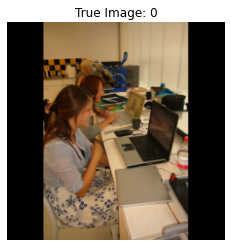

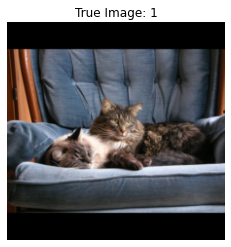

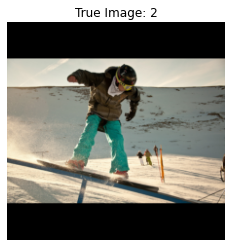

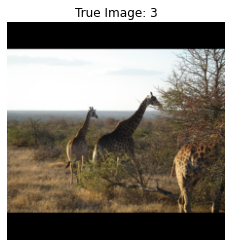

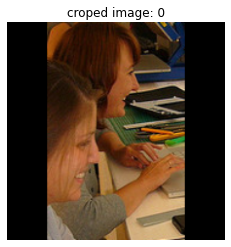

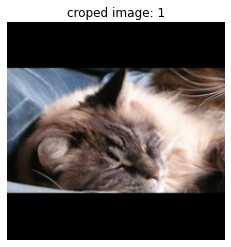

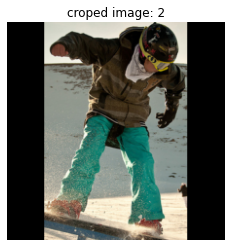

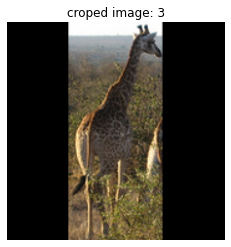

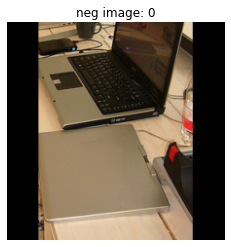

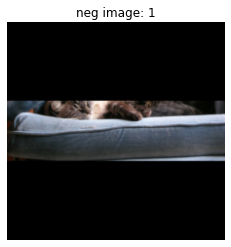

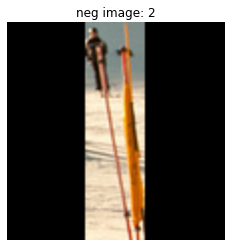

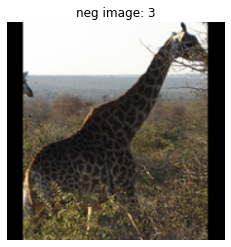


 The sentences tensor (Seq , Batch) is:
tensor([[   1,    1,    1,    1],
        [3141,    4,   10,   10],
        [  58,  262,  550,  872],
        [  18,   46,   14,    5],
        [   4,   80,   10,   12],
        [ 262,   88, 3976,    2],
        [ 764,  922,   43,    0],
        [ 601,  206,  127,    0],
        [   4,    8, 6618,    0],
        [ 155,   88,   12,    0],
        [ 181,    2,    2,    0],
        [  12,    0,    0,    0],
        [   2,    0,    0,    0]], device='cuda:0')

 The sentences length tensor (Seq ) is:
[13, 11, 11, 6]


In [97]:
################# testing dataset and dataloader #########################
CompData = CompDataset(csv_file= 'dataset/dataset.valid.csv', root_dir='mscoco', 
                           regions_file= 'regions_valid.pickle',transform_sent=ToTensor(sent_vocab))

datax = DataLoader(CompData, batch_size=4,
                        shuffle=True, num_workers=0, collate_fn =PadCollate_Comp())

for i, ci , neg ,s ,  l  in datax:
  for c  in range(i.shape[0]):
    plt.imshow(np.transpose(i[c],(1,2, 0)))
    plt.title("True Image: {}".format(c))
    # print(i[c].shape)
    plt.axis('off')
    plt.show()

  for c  in range(ci.shape[0]):
    plt.imshow(np.transpose(ci[c],(1,2, 0)))
    plt.title("croped image: {}".format(c))
    # print(ci[c].shape)
    plt.axis('off')
    plt.show()

  for c  in range(neg.shape[0]):
    plt.imshow(np.transpose(neg[c],(1,2, 0)))
    plt.title("neg image: {}".format(c))
    # print(ci[c].shape)
    plt.axis('off')
    plt.show()

  print('\n The sentences tensor (Seq , Batch) is:')
  print(s)
  print('\n The sentences length tensor (Seq ) is:')
  print(l)
  break


###5.3. Training Loop

In [90]:
batch_size = 16


train_dataset = CompDataset(csv_file= 'dataset/dataset.train.csv', root_dir='mscoco',
                          regions_file= 'regions_train.pickle',transform_sent=ToTensor(sent_vocab))

valid_dataset = CompDataset(csv_file= 'dataset/dataset.valid.csv', root_dir='mscoco',
                          regions_file= 'regions_valid.pickle', transform_sent=ToTensor(sent_vocab))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, 
                              shuffle=True, num_workers=0, collate_fn = PadCollate_Comp())

valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, 
                              shuffle=False, num_workers=0, collate_fn = PadCollate_Comp())



In [91]:
model = GeneratorNet(1000, 1024, 1024, sent_vocab.size)
model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=4,gamma=0.1)
frames = pd.read_csv('dataset/dataset.valid.csv')
la = 1


In [39]:
model.load_state_dict(torch.load('/content/gdrive/My Drive/models/model_res50_t_12.chkpt'))

<All keys matched successfully>

In [ ]:
max_epoch = 4
log_every = 500
val_every = 2500
batch_count = 0
plot_losses_train = []
plot_losses_eval = []
x_t = []
x_v = []
################ training loop ######################
for i in range(max_epoch):
    print('Epoch:', i+1)
    running_loss = 0.0
    for batch, data in enumerate(train_dataloader):
        batch_count +=1
        model.train()
        optimizer.zero_grad()
        image, pos_image, neg_image, sents , _ = data
        _, score_pos = model(image.to(DEVICE), pos_image.to(DEVICE) , sents.to(DEVICE))
        _, score_neg = model(image.to(DEVICE), neg_image.to(DEVICE) , sents.to(DEVICE))
        loss = - (score_pos - la*torch.clamp(score_neg - score_pos, min=0))
        loss = loss.sum()/batch_size
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
        optimizer.step()
        running_loss += loss.item()

        if batch % log_every == log_every - 1:
            print(">>> loss: %.3f', batch number= %d" %(running_loss/(batch+1),batch + 1))
            plot_losses_train.append(running_loss/(batch+1))
            x_t.append(batch_count)

            
        torch.cuda.empty_cache()

    lr_scheduler.step()
    torch.save(model.state_dict(), '/content/gdrive/My Drive/models/model_res50_comp_{}.chkpt'.format(str(i+1)))


plt.plot(x_t ,plot_losses_train, '-g', label='train')
# plt.plot(x_v , plot_losses_eval, '-r', label='validation')

plt.xlabel('batch count')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.show()


###5.4. Perecision Score for Comprehension
In this section, we use the given function to evaluate our precission

In [100]:
model.load_state_dict(torch.load('/content/gdrive/My Drive/models/model_res50_t_12.chkpt'))

<All keys matched successfully>

In [83]:
valid_dataset = CompDataset(csv_file= 'dataset/dataset.valid.csv', root_dir='mscoco',
                          regions_file= 'regions_valid.pickle', transform_sent=ToTensor(sent_vocab))

frames = pd.read_csv('dataset/dataset.valid.csv')
regions = torch.load('regions_valid.pickle')

model = model.to(DEVICE)
boxes_f = []
with torch.no_grad():
    model.eval()
    for idx in tqdm(range(len(valid_dataset))):
        score = None
        im_p = []
        sent_tensor = valid_dataset[idx]['sentence'].unsqueeze(1)
        image = valid_dataset[idx]['image_u']
        image_t = valid_dataset[idx]['image']
        image_name = valid_dataset[idx]['img_name']
        boxes = regions[image_name]['boxes']
        
        images_t = torch.stack([image_t for i in range(len(boxes))], dim=0)
        sents = torch.stack([sent_tensor for i in range(len(boxes))], dim=1).squeeze()

        for j in range(len(boxes)):
          item = boxes[j]
          image_p = ImageResize(torchvision.transforms.functional.crop(image , int(item[1]), int(item[0]), int(item[3]- item[1]),int(item[2] -item[0])))
          im_p.append(image_p)
        
        images_p = torch.stack(im_p, dim=0)
        _, s = model(images_t.to(DEVICE), images_p.to(DEVICE) , sents.to(DEVICE))
        
        _ , index = torch.max(s.squeeze(), 0)

        a = boxes[index]
        temp = torch.tensor([a[0],a[1],a[2]-a[0] , a[3] -a[1]])
        boxes_f.append(temp)

eval =  eval_precision(frames, boxes_f)
print('eval precision measure is:', eval)


eval precision measure is: (0.5066394279877426, tensor(0.5021))


##6. Test our Model
In this section, we test our network and complete test files.

###6.1. Generation Test


In [52]:
class GenTestDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform_sent=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.frames = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform_sent = transform_sent

    def __len__(self):
        return len(self.frames)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        ############## id to crop location ############
        crop_loc = self.frames.iloc[idx, 2].split ("[")[1].split("]")[-2].split()
        crop_loc = [float(i) for i in crop_loc]
        ############## id to image ############
        img_name = os.path.join(self.root_dir, self.frames.iloc[idx, 1])
        image = Image.open(img_name )
        image = image.convert('RGB')
        croped_image = torchvision.transforms.functional.crop(image , int(crop_loc[1]), int(crop_loc[0]), int(crop_loc[3]),int(crop_loc[2]))
        
        image = ImageResize(image)
        croped_image = ImageResize(croped_image)

        sample = {'image': image, 'croped_image': croped_image , 'crop_loc': crop_loc}

        return sample


class ToTensor(object):
    """A callable transform that converts sentences to Tensors.
    """
    def __init__(self, src_vocab: Vocab):
        self.src_vocab = src_vocab

    def __call__(self, sents: Dict):
        return self.src_vocab.to_tensor(sents)

In [53]:
test_dataset = GenTestDataset(csv_file= 'dataset.test.gen.csv', root_dir='mscoco', 
                          transform_sent=ToTensor(sent_vocab))

frames = pd.read_csv('dataset.test.gen.csv')


sentences = []
with torch.no_grad():
    model.eval()
    for idx in range(len(test_dataset)):
        image = test_dataset[idx]['image']
        image_c  = test_dataset[idx]['croped_image']
        temp = model.greedy_decode(image.to(DEVICE), image_c.to(DEVICE), sent_vocab)
        temp = temp[0:-1]
        listToStr = ' '.join(temp)
        sentences.append(listToStr)

print("writing on generation csv file ....")
frames['sentence'] = sentences
frames.to_csv('dataset.test.gen.csv',index=False)
print("generation csv file completed :)")
print("writing on generation txt file ....")
my_test = open('sentences.txt', 'w')
for item in sentences:
  my_test.write(item + '\n')
my_test.close()
print("generation txt file completed :)")


writing on generation csv file ....
generation csv file completed :)
writing on generation txt file ....
generation txt file completed :)


In [101]:
test_dataset = GenTestDataset(csv_file= 'dataset.test.gen.csv', root_dir='mscoco', 
                          transform_sent=ToTensor(sent_vocab))

frames = pd.read_csv('dataset.test.gen.csv')


sentences = []
with torch.no_grad():
    model.eval()
    for idx in tqdm(range(len(test_dataset))):
        image = test_dataset[idx]['image']
        image_c  = test_dataset[idx]['croped_image']
        temp = model.greedy_decode(image.to(DEVICE), image_c.to(DEVICE), sent_vocab)
        temp = temp[0:-1]
        listToStr = ' '.join(temp)
        sentences.append(listToStr)

print("writing on generation csv file ....")
frames['sentence'] = sentences
frames.to_csv('dataset.test.gen.csv',index=False)
print("generation csv file completed :)")
print("writing on generation txt file ....")
my_test = open('sentences.txt', 'w')
for item in sentences:
  my_test.write(item + '\n')
my_test.close()
print("generation txt file completed :)")


writing on generation csv file ....
generation csv file completed :)
writing on generation txt file ....
generation txt file completed :)


###6.2. Comprehension Test

In [62]:
class CompTestDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform_sent=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.frames = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform_sent = transform_sent

    def __len__(self):
        return len(self.frames)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        ############## id to image ############
        img_name = os.path.join(self.root_dir, self.frames.iloc[idx, 1])
        image = Image.open(img_name )
        image = image.convert('RGB')
        
        ############## id to sentence ############
        sentence = self.frames.iloc[idx, 2]
        sentence = sentence.lower()
        sentence = word_tokenize(sentence)
        sentence.insert(0, '<START>')
        sentence.append('<END>')
        # print(sentence)
        if self.transform_sent:
          sentence = self.transform_sent(sentence)

        sample = {'image': image, 'sentence': sentence}

        return sample


class ToTensor(object):
    """A callable transform that converts sentences to Tensors.
    """
    def __init__(self, src_vocab: Vocab):
        self.src_vocab = src_vocab

    def __call__(self, sents: Dict):
        return self.src_vocab.to_tensor(sents)

In [78]:
comp_test_dataset = CompTestDataset(csv_file= 'dataset.test.comp.csv', root_dir='mscoco', transform_sent=ToTensor(sent_vocab))

frames = pd.read_csv('dataset.test.comp.csv')

detector = models.detection.fasterrcnn_resnet50_fpn(pretrained=True).to(DEVICE)

model = model.to(DEVICE)
boxes_f = []

with torch.no_grad():
    model.eval()
    detector.eval()
    for idx in tqdm(range(len(comp_test_dataset))):
        im_p = []
        sent_tensor = comp_test_dataset[idx]['sentence'].unsqueeze(1)
        image = comp_test_dataset[idx]['image']
        image_t = ImageResize(image)

        boxes = detector([transforms.functional.to_tensor(image).to(DEVICE)])[0]['boxes']
        
        images_t = torch.stack([image_t for i in range(len(boxes))], dim=0)
        sents = torch.stack([sent_tensor for i in range(len(boxes))], dim=1).squeeze()

        for j in range(len(boxes)):
          item = boxes[j]
          image_p = ImageResize(torchvision.transforms.functional.crop(image , int(item[1]), int(item[0]), int(item[3]- item[1]),int(item[2] -item[0])))
          im_p.append(image_p)
        
        images_p = torch.stack(im_p, dim=0)
        _, s = model(images_t.to(DEVICE), images_p.to(DEVICE) , sents.to(DEVICE))
        
        _ , index = torch.max(s.squeeze(), 0)
        a = boxes[index]
        boxes_f.append(str(int(a[0]))+', '+ str(int(a[1]))+', '+ str(int(a[2]-a[0]))+', '+ str(int(a[3]-a[1])))

print("writing on comprehension csv file ....")
frames['box'] = boxes_f
frames.to_csv('dataset.test.comp.csv',index=False)
print("comprehension csv file completed :)")

print("writing on comprehension txt file ....")
my_test = open('boxes.txt', 'w')
for item in boxes_f:
  my_test.write(item + '\n')
my_test.close()
print("comprehension txt file completed :)")



/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "



writing on comprehension csv file ....
comprehension csv file completed :)
writing on comprehension txt file ....
comprehension txt file completed :)
